In [1]:
import os
import sys
import yaml
import tifffile
from pathlib import Path

import numpy as np
from math import ceil

import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

sys.path.append(os.path.abspath(os.path.join('..')))

import src.gui as gui

In [2]:
data_path = Path('../data/')

In [3]:
vol = tifffile.imread(data_path / '1099.tif')
label = tifffile.imread(data_path / '1099_brain_clean.tif')

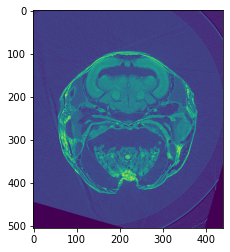

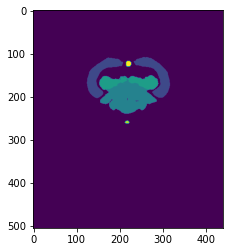

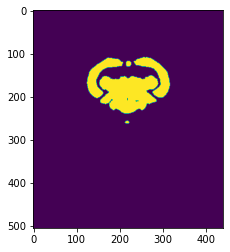

In [4]:
slice_num = 282

plt.imshow(vol[slice_num])
plt.show()

plt.imshow(label[slice_num])
plt.show()

#print(vol.dtype)
#print(label.dtype)

# Remove optic nerve, with label ID=1
#label[label == 1] = 0

label_merged = (label > 0).astype(int)
plt.imshow(label_merged[slice_num])
plt.show()

In [14]:
itk_label = sitk.GetImageFromArray(label)
itk_label_merged = sitk.GetImageFromArray(label_merged)
itk_img = sitk.GetImageFromArray(vol)

shape_stats = sitk.LabelShapeStatisticsImageFilter()

shape_stats.ComputeOrientedBoundingBoxOn()
#shape_stats.ComputeFeretDiameterOn()

shape_stats.Execute(itk_label_merged)

[0.011255200063116364, -0.9999113340509881, 0.007116495479694711, 0.9641142545497218, 0.008963829000760289, -0.2653363034785855, 0.2652489861348656, 0.009847527914071567, 0.9641296601331211]


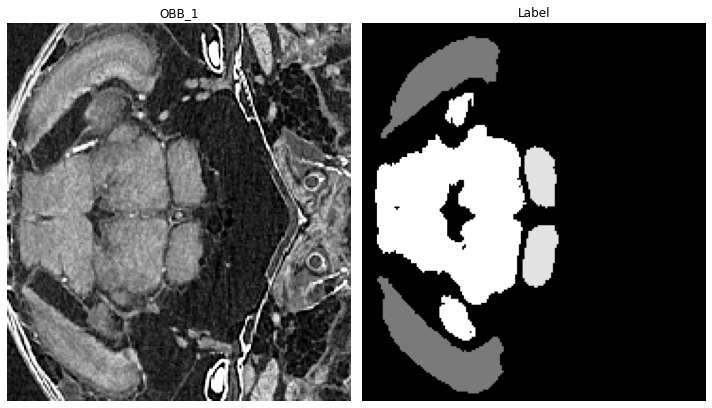

In [15]:
resampler = sitk.ResampleImageFilter()
aligned_image_spacing = [1,1,1] #in nanometers

label_num = 1

aligned_image_size = [ int(ceil(shape_stats.GetOrientedBoundingBoxSize(label_num)[i]/aligned_image_spacing[i])) for i in range(3) ]

#print(aligned_image_size)

direction_mat = shape_stats.GetOrientedBoundingBoxDirection(label_num)
aligned_image_direction = [direction_mat[0], direction_mat[3], direction_mat[6], 
                           direction_mat[1], direction_mat[4], direction_mat[7],
                           direction_mat[2], direction_mat[5], direction_mat[8] ]

print(aligned_image_direction)

resampler.SetOutputDirection(aligned_image_direction)
resampler.SetOutputOrigin(shape_stats.GetOrientedBoundingBoxOrigin(label_num))
resampler.SetOutputSpacing(aligned_image_spacing)
resampler.SetSize(aligned_image_size)
resampler.SetInterpolator(sitk.sitkNearestNeighbor)

#print(direction_mat)

obb_img = resampler.Execute(itk_img)
obb_label = resampler.Execute(itk_label)


# Change the image axes order so that we have a nice display.
#obb_img = sitk.PermuteAxes(obb_img,[2,1,0])
#obb_label = sitk.PermuteAxes(obb_label,[2,1,0])

gui.MultiImageDisplay(image_list = [obb_img, obb_label],                   
                      title_list = ["OBB_{0}".format(label_num), 'Label'])

(476, 200, 182)


(-0.5, 181.5, 199.5, -0.5)

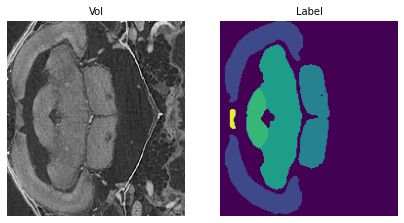

In [16]:
# Display the image slice from the middle of the stack, z axis
z = 220
np_img = sitk.GetArrayViewFromImage(obb_img)
np_label = sitk.GetArrayViewFromImage(obb_label)

print(np_img.shape)


img_slice = np_img[z,:,:]
img_label = np_label[z,:,:]

# Three plots displaying the same data, how do we deal with the high dynamic range?
fig = plt.figure(figsize=(7,7))

fig.add_subplot(1,2,1)
plt.imshow(np.flipud(img_slice), cmap='gray')
plt.title('Vol', fontsize=10)
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(np.flipud(img_label));
plt.title('Label', fontsize=10)
plt.axis('off')



In [17]:
im = Image.fromarray(img_label.T)
im.save("image.tif")

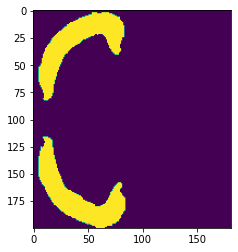

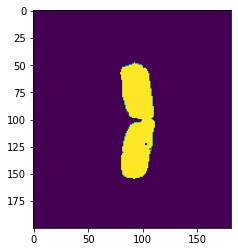

In [23]:
label_tectum = np_label.copy()
label_midbrain = np_label.copy()

label_tectum[label_tectum != 2] = 0
label_tectum[label_tectum == 2] = 1


label_midbrain[label_midbrain != 4] = 0
label_midbrain[label_midbrain == 4] = 1

plt.imshow(label_tectum[z])
plt.show()

plt.imshow(label_midbrain[z])
plt.show()

In [24]:
itk_tectum_label = sitk.GetImageFromArray(label_tectum)
itk_midbrain_label = sitk.GetImageFromArray(label_midbrain)

shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()

shape_stats.Execute(itk_tectum_label)
centroid_tectum = shape_stats.GetCentroid(1)

shape_stats.Execute(itk_midbrain_label)
centroid_midbrain = shape_stats.GetCentroid(1)


In [25]:
print(centroid_tectum)
print(centroid_midbrain)

(43.167484707371294, 99.68601028703088, 192.8742515941653)
(86.22807411897999, 101.44435967822136, 178.56120537569223)
